### **Pairs Trading Strategies Using Python Part 1**


In [46]:
import yfinance as yf
import statsmodels.tsa.stattools as ts
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

# Define the Dow Jones stocks you want to analyze
dow_jones_tickers = [
    "AAPL", "AMGN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS", "DOW",
    "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM",
    "MRK", "MSFT", "NKE", "PG", "TRV", "UNH", "V", "VZ", "WBA", "WMT",
    "MMM", "HWM", "BA", "IBM", "TRV", "NKE", "DOW", "GS", "CAT", "CVX",
    "MSFT", "DIS", "MCD", "V", "UNH", "JPM", "HD", "AAPL", "HON", "WMT",
    "INTC", "PG", "AMGN", "WBA", "JNJ", "CSCO", "CRM", "KO"
]
# Fetch historical data for the Dow Jones stocks
data = yf.download(dow_jones_tickers, start="2021-01-01", end="2023-01-01")["Adj Close"]


[*********************100%***********************]  31 of 31 completed


In [47]:
# Find pairs of stocks with high correlation
pairs = []
correlation_threshold = 0.75

for stock1, stock2 in combinations(dow_jones_tickers, 2):
    if stock1 != stock2:  # Remove pairs with themselves
        correlation = data[stock1].corr(data[stock2])
        if correlation > correlation_threshold:
            pair = tuple(sorted([stock1, stock2]))  # Sort to eliminate duplicates
            if pair not in pairs:
                pairs.append(pair)

# Perform cointegration analysis
for pair in pairs:
    stock1 = pair[0]
    stock2 = pair[1]

    cointegration_test = ts.coint(data[stock1], data[stock2])
    p_value = cointegration_test[1]

    if p_value < 0.05:
        cointegration_results = cointegration_results.append(
            {"Pair": f"{stock1}-{stock2}", "Cointegration P-Value": p_value},
            ignore_index=True)
        
# Initialize an empty DataFrame to store cointegration test results
cointegration_results = pd.DataFrame(cointegration_results,columns=["Pair", "Cointegration P-Value"])
cointegration_results

,Pair,Cointegration P-Value
0,CVX-TRV,0.033856
1,HWM-IBM,0.004284
2,INTC-VZ,0.027672
3,JNJ-KO,0.005744
4,JNJ-TRV,0.022132
5,JPM-NKE,0.049603
6,HWM-KO,0.006521
7,HWM-TRV,0.010567
8,CVX-TRV,0.033856
9,HWM-IBM,0.004284


In [49]:
# Print eligible pairs for pair trading
print("Eligible Pairs for Pair Trading:")
for idx, row in cointegration_results.iterrows():
    print(row["Pair"])

# Plot cumulative returns, stocks' returns, and buy/sell signals for selected pairs
pairs_to_plot = cointegration_results["Pair"].head(5)  # Plot first 5 pairs for illustration


Eligible Pairs for Pair Trading:
CVX-TRV
HWM-IBM
INTC-VZ
JNJ-KO
JNJ-TRV
JPM-NKE
HWM-KO
HWM-TRV
CVX-TRV
HWM-IBM
INTC-VZ
JNJ-KO
JNJ-TRV
JPM-NKE
HWM-KO
HWM-TRV
CVX-TRV
HWM-IBM
INTC-VZ
JNJ-KO
JNJ-TRV
JPM-NKE
HWM-KO
HWM-TRV
CVX-TRV
HWM-IBM
INTC-VZ
JNJ-KO
JNJ-TRV
JPM-NKE
HWM-KO
HWM-TRV


In [51]:
# Implement pair trading strategy and plot cumulative returns for selected pairs
def pair_trading_strategy(data, pair):
    stock1 = pair[0]
    stock2 = pair[1]

    spread = data[stock1] - data[stock2]
    spread_mean = spread.mean()
    spread_std = spread.std()

    zscore = (spread - spread_mean) / spread_std

    # Define entry and exit thresholds for the z-score
    entry_threshold = 0.8
    exit_threshold = 0.2

    long_signal = zscore < -entry_threshold
    short_signal = zscore > entry_threshold
    exit_signal = abs(zscore) < exit_threshold

    positions = pd.DataFrame(index=data.index)
    positions[stock1] = 0
    positions[stock2] = 0

    # Enter long position in stock1 and short position in stock2
    positions.loc[long_signal, stock1] = 1
    positions.loc[long_signal, stock2] = -1

    # Enter short position in stock1 and long position in stock2
    positions.loc[short_signal, stock1] = -1
    positions.loc[short_signal, stock2] = 1

    # Exit positions
    positions.loc[exit_signal, stock1] = 0
    positions.loc[exit_signal, stock2] = 0

    # Calculate portfolio returns
    portfolio_returns = (positions.shift(1) * (data.pct_change())).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()

    return cumulative_returns, positions

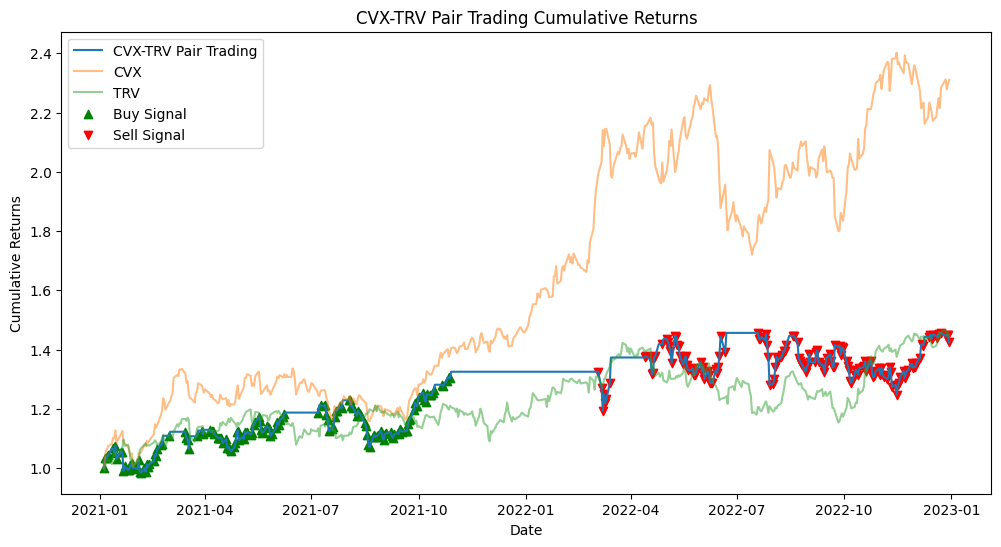

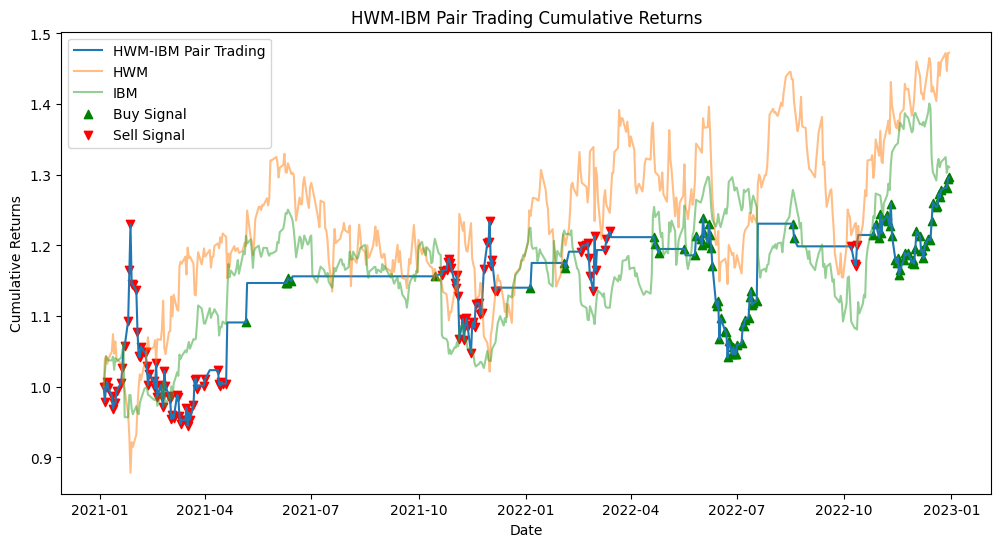

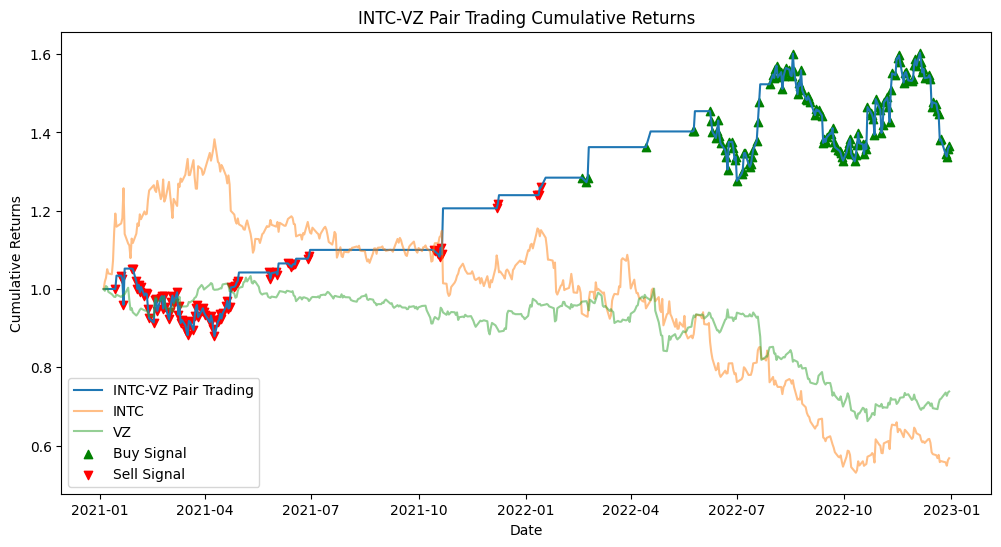

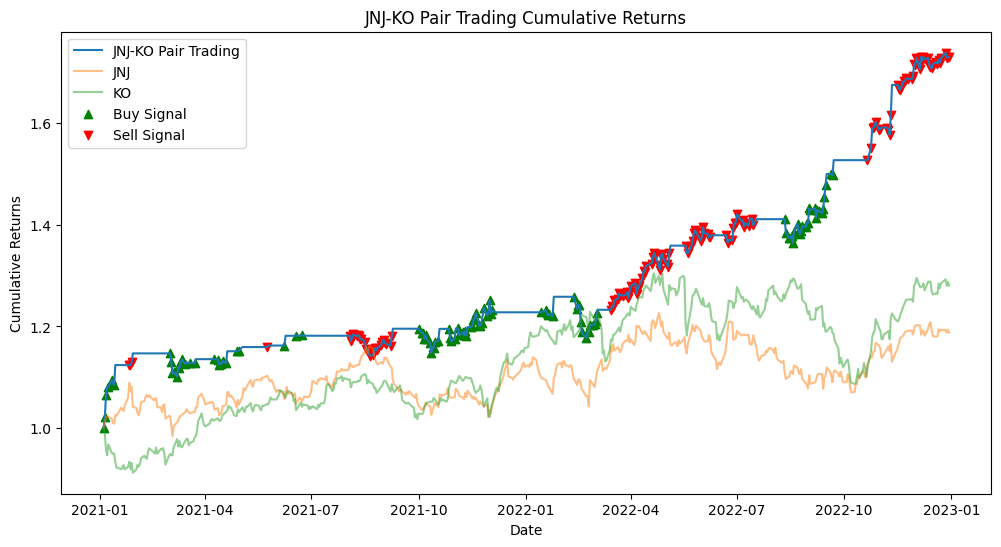

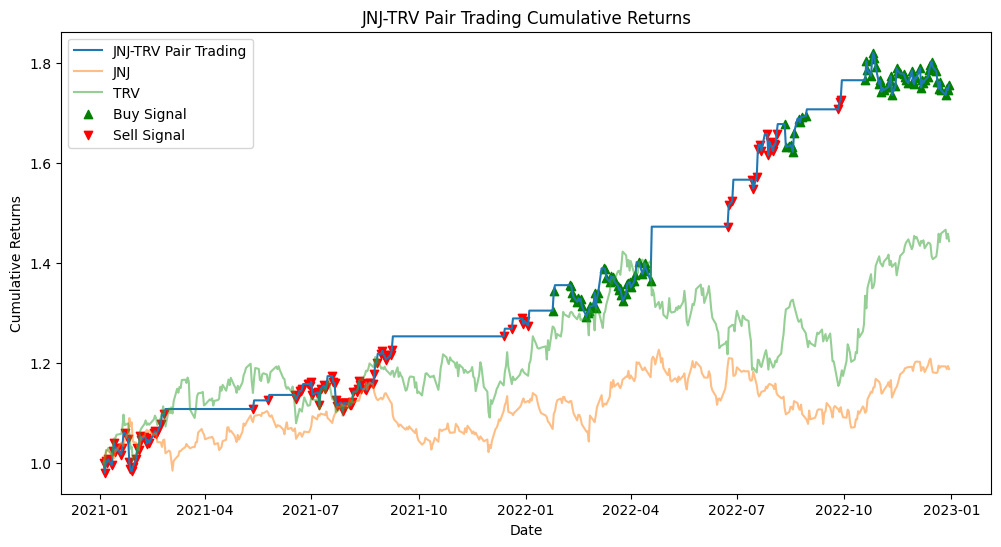

In [52]:
for pair in pairs_to_plot:
    stock1, stock2 = pair.split("-")
    cumulative_returns, positions = pair_trading_strategy(data, (stock1, stock2))

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label=f"{stock1}-{stock2} Pair Trading")
    plt.title(f"{stock1}-{stock2} Pair Trading Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()

    # Plot stocks' returns in the background
    plt.plot(data[stock1] / data[stock1].iloc[0], alpha=0.5, label=stock1)
    plt.plot(data[stock2] / data[stock2].iloc[0], alpha=0.5, label=stock2)

    # Plot buy/sell signals on the chart
    buy_signals = positions[stock1][positions[stock1] == 1]
    sell_signals = positions[stock1][positions[stock1] == -1]
    plt.scatter(buy_signals.index, cumulative_returns.loc[buy_signals.index], marker="^", color="g", label="Buy Signal")
    plt.scatter(sell_signals.index, cumulative_returns.loc[sell_signals.index], marker="v", color="r", label="Sell Signal")

    plt.legend()
    plt.show()
